In [211]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [60]:
data = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", low_memory = False);

In [61]:
columns_to_drop = ['id', 'member_id', 'emp_title']
data = data.drop(columns_to_drop, axis = 1)
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,10400,10400,10400,36 months,6.99%,321.08,A,A3,8 years,MORTGAGE,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,15000,15000,15000,60 months,12.39%,336.64,C,C1,10+ years,RENT,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,12800,12800,12800,60 months,17.14%,319.08,D,D4,10+ years,MORTGAGE,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,7650,7650,7650,36 months,13.66%,260.20,C,C3,< 1 year,RENT,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,9600,9600,9600,36 months,13.66%,326.53,C,C3,10+ years,RENT,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
def initial_model(df, columns, columns_to_encode):
    new_df = df.copy()
    new_df = new_df[columns]
    new_df = pd.get_dummies(new_df, dummy_na = True, columns = columns_to_encode)
    return new_df

In [347]:
cols = ['funded_amnt', 'grade', 'emp_length', 'home_ownership',
        'annual_inc', 'verification_status', 'dti', 'loan_status'] #, 'revol_util']
cols_encode = ['grade', 'emp_length', 'home_ownership', 'verification_status']

new_df = initial_model(data, cols, cols_encode)

In [348]:
new_df.head()

,funded_amnt,annual_inc,dti,loan_status,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,...,emp_length_< 1 year,emp_length_nan,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan
0,10400,58000.0,14.92,Charged Off,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,15000,78000.0,12.03,Fully Paid,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,12800,125000.0,8.31,Current,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,7650,50000.0,34.81,Charged Off,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,9600,69000.0,25.81,Fully Paid,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [349]:
new_df = new_df[new_df.loan_status != 'Current'];

In [350]:
new_df.groupby('loan_status').size()

loan_status
Charged Off           10308
Default                  11
Fully Paid            43806
In Grace Period          96
Late (16-30 days)        49
Late (31-120 days)      177
dtype: int64

In [351]:
new_df['paid'] = 1;
new_df.loc[new_df.loan_status == 'Fully Paid', 'paid'] = 0;
display(new_df.head())

,funded_amnt,annual_inc,dti,loan_status,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,...,emp_length_nan,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,paid
0,10400,58000.0,14.92,Charged Off,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,15000,78000.0,12.03,Fully Paid,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,7650,50000.0,34.81,Charged Off,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,9600,69000.0,25.81,Fully Paid,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5,21425,63800.0,18.49,Fully Paid,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [352]:
data_train, data_test = train_test_split(new_df, test_size=.5, stratify=new_df.paid, random_state=99);

In [353]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

In [354]:
cols_to_drop_training = ['loan_status', 'paid']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [355]:
model = LogisticRegressionCV(cv = 5, multi_class='ovr', penalty = 'l2')
model.fit(x_train, y_train);

In [356]:
model.score(x_train, y_train)

0.804577012085369

In [357]:
model.score(x_test, y_test)

0.8045474581251837

In [358]:
predictions = x_train.copy()
predictions['pred'] = model.predict(x_train)
predictions['proba'] = model.predict_proba(x_train)[:, 1]
predictions['true_val'] = y_train

In [359]:
predictions.head()

,funded_amnt,annual_inc,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,...,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,pred,proba,true_val
29375,7200,26000.0,37.90,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0.230713,0
14211,30000,180000.0,22.30,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.052093,0
435,21000,85814.0,21.79,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0.183674,0
27019,7000,34396.0,22.92,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0.271994,0
48648,12000,56000.0,35.49,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0.176612,0


In [360]:
predictions['class'] = 0;
predictions.loc[predictions.proba > 0.39, 'class'] = 1;
display(predictions.head())

,funded_amnt,annual_inc,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,...,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,pred,proba,true_val,class
29375,7200,26000.0,37.90,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0.230713,0,0
14211,30000,180000.0,22.30,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0.052093,0,0
435,21000,85814.0,21.79,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0.183674,0,0
27019,7000,34396.0,22.92,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0.271994,0,0
48648,12000,56000.0,35.49,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0.176612,0,0


In [361]:
accuracy_score(y_train, predictions['class'])

0.7988098299232267

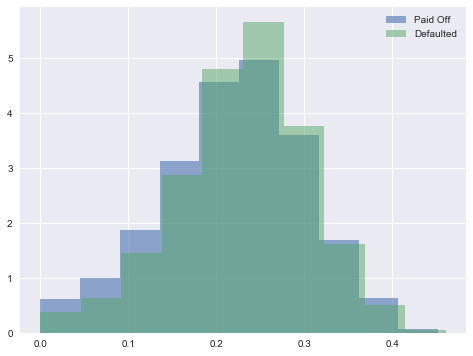

In [363]:
fig = plt.figure(figsize=(8,6));
ax = plt.subplot(1,1,1);



ax.hist(predictions.loc[predictions.true_val == 0,'proba'], density = True, bins = 10, label='Paid Off', alpha=0.6);
ax.hist(predictions.loc[predictions.true_val == 1,'proba'], density = True, bins = 10, label='Defaulted', alpha=0.5);
ax.legend(loc='best')

plt.show()